In [2]:
import pandas as pd
import numpy as np

from numpy.typing import NDArray
import seaborn as sns

In [152]:
"""
Collect the Dataset, pro Downloaded from my Harddrive. It consists of some raw closes of Crypto Prices in a minute Interval
"""

data = pd.read_csv("spot_data_merged.csv", index_col="timestamp")
data.index = pd.to_datetime(data.index)
data_re = data.resample("3h").last()

#Resampled the Data to 15minute Interval, as it generally tends to correlate more over longer timeframes

data_re.dropna(axis = 1, inplace = True)
data_re.index = pd.to_datetime(data_re.index)

test = int(round(data_re.values.shape[0] * 0.15, 0))  #use 15% of the length as testing data

data2 = data_re[:-test]
data2_test = data_re[-test:]

'\nThis includes the correlation Matrix of the Crypto Prices; While the first ones are less correlated, the later ones seem to be more corr.\nThis may be from the fact that the download list for the tickers was ChatGPT generated, so the more famous Cryptos are in the beginning\nWhile higher correlated pairs might be at the end (move less on their own, as they have less community//news but idk for sure\n\n'

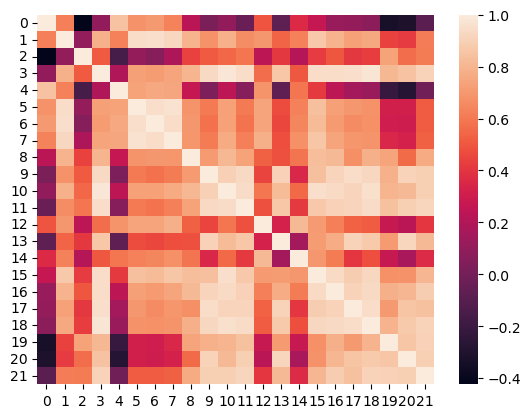

In [154]:
corr2 = np.corrcoef(data2.T)
sns.heatmap(corr2)


"""
This includes the correlation Matrix of the Crypto Prices; While the first ones are less correlated, the later ones seem to be more corr.
This may be from the fact that the download list for the tickers was ChatGPT generated, so the more famous Cryptos are in the beginning
While higher correlated pairs might be at the end (move less on their own, as they have less community//news but idk for sure

"""

In [156]:
from scipy.linalg import fractional_matrix_power

"""
This function Really just Retunrs the eigenvalue solution, minimizing the Ratio of Variance across time to the variance of the day 
(between this asset)
This in theory should at least better capture the dynamics of Mean Revision, less variance and correlation across time (no trend)
while maintaining tradeable intra-day (or intra timeframe Variance)
"""


def get_weights(data, p, mode= 1):
    data = data.fillna(0)
    data = data.values
    
    #data = data[1:, :] / data[:-1, :] -1
    data = data[1:, :]

    m = data.shape[0]

    
    if mode == 1:
        demeaned_data = (data - np.mean(data, axis = 0)) / np.std(data, axis = 0)
    
    elif mode == 2:
        demeaned_data = data - np.mean(data, axis = 0)

    else:
        demeaned_data = data
        
    cov_ = 1/(m-1) * (demeaned_data.T @ demeaned_data)
    cov_lag = 1/(m-p-1) * (demeaned_data[:-p, :].T @ demeaned_data[p:, :])

    #project each asset vector onto another to get similarities, approx of the Cov Matrix
    cov_inv = fractional_matrix_power(cov_, -0.5)
    
    eig_value, eig_vector = np.linalg.eig(cov_inv @ cov_lag @ cov_inv)
    min_vector = eig_vector[np.argmin(eig_value)]
    weights = cov_inv @min_vector.T
    
    if mode == 1:
        return demeaned_data, weights.real / np.std(data, axis = 0), np.std(data, axis = 0)

    else:
        return demeaned_data, weights.real, np.std(data, axis = 0)


import seaborn as sns

<Axes: xlabel='timestamp'>

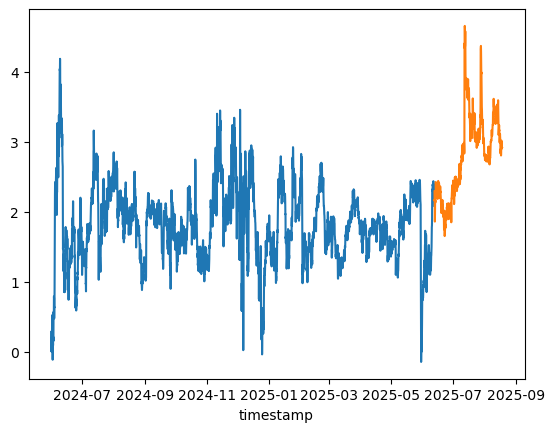

In [158]:
data3, z1, std = get_weights(data2, 1, mode = 2)    

"""
#mode = 1 sets it to normalization mode, but you have to adjust the weights back
#mode = 2 sets just demeaning, with different std

In mode one the Variances differ a lot, but it may be more realistic as Variance changes over time, so if the calculations work 
without adjustment, then we can 
"""
returns = data2 @ (z1)
sns.lineplot(returns)
sns.lineplot(data2_test @ z1)


'\nThis plot blow essentially shows the optimized Portfolio weights applied to trainign and testing data\nIt shows that for the testing periods, the Stationarity is roughly in line with the training data, on first sight rejecting the idea of \noverfitted values, but longer time series are needed to proof it\n'

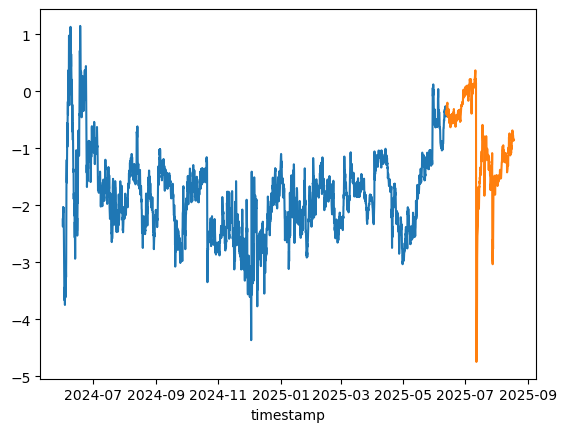

In [159]:
data3, z1, std = get_weights(data2, 1, mode = 1)    #mode = 2 sets just demeaning, with different std
                                                    #mode = 1 sets it to normalization mode, but you have to adjust the weights back
returns = data2 @ (z1)
sns.lineplot(returns)
sns.lineplot(data2_test @ z1)

"""
This plot blow essentially shows the optimized Portfolio weights applied to trainign and testing data
It shows that for the testing periods, the Stationarity is roughly in line with the training data, on first sight rejecting the idea of 
overfitted values, but longer time series are needed to proof it
"""

In [162]:
def mean_revision_signals(data: NDArray, weights: NDArray, limit: float, factor_trade: float, alpha = 0.05):
    val_data = data.values
    val_weight = weights #.values

    m = data.shape[0]
    
    ema_list = np.zeros(m)
    buy_border_list = np.zeros(m)
    sell_border_list = np.zeros(m)

    signal_list = np.zeros(m)

    try:
        portfolio = val_data @ val_weight
        portfolio = np.squeeze(portfolio)
        ema = np.mean(portfolio[:limit])
        std = np.std(portfolio[:limit])

        direction = 0
        
        for i in range(limit, portfolio.shape[0]):
            ema = portfolio[i] * alpha + (1-alpha) * ema
            std = np.std(portfolio[i-limit:i])   #(portfolio[i] - ema)**2 * alpha + (1-alpha) * std
            
            ema_list[i] = ema
            
            buy_border = ema - factor_trade * std
            sell_border = ema + factor_trade * std

            buy_border_list[i] = buy_border
            sell_border_list[i] = sell_border

        #Sell Side Coverage
            #open a short position
            if signal_list[i-1] == 0 and portfolio[i] >= sell_border:
                signal_list[i] = -1

            #keep a short position open:
            if signal_list[i-1] == -1 and portfolio[i] >= ema:
                signal_list[i] = -1

            #close position
            if signal_list[i-1] == -1 and portfolio[i] <= ema:
                signal_list[i] = 0

    
        #Buy Side Coverage
            #open a short position
            if signal_list[i-1] == 0 and portfolio[i] <= buy_border:
                signal_list[i] = 1

            #keep a long position open:
            if signal_list[i-1] == 1 and portfolio[i] <= ema:
                signal_list[i] = 1

            #close position
            if signal_list[i-1] == 1 and portfolio[i] >= ema:
                signal_list[i] = 0

        signal_list = signal_list.reshape(-1, 1)
        val_weight = val_weight.reshape(-1, 1)
        
        asset_weights = signal_list * val_weight.T
        

        asset_returns = val_data[1:, :] / val_data[:-1, :] - 1
        asset_weights = asset_weights[:-1, :]

        portfolio_returns = asset_returns * asset_weights
        portfolio = portfolio_returns @ np.ones(22).T 

        
        adjusting_factor = 0.1 / ((365 * 12)**(1/2) * np.std(portfolio))

        portfolio = portfolio * adjusting_factor + 1

                                                             
        print(asset_weights.shape)
        print(asset_returns.shape)
        print(portfolio_returns.shape)
        
        return ema_list, buy_border_list, sell_border_list, val_data, portfolio, val_weight
        
    
    except Exception as e:
        print(e)
    

    

(3012, 22)
(3012, 22)
(3012, 22)


<Axes: >

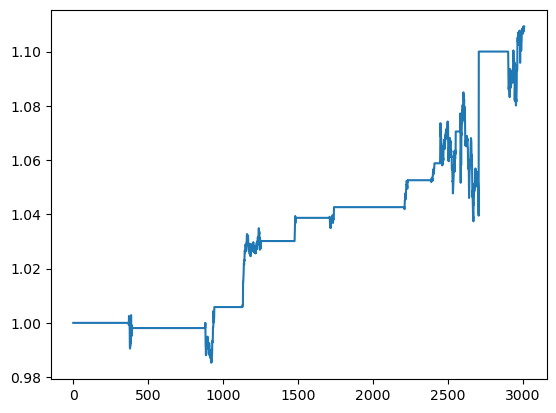

In [164]:
ema, buy_border_list, sell_border_list, val_data, portfolio, weight = mean_revision_signals(data2, z1, 100, 3, alpha=0.01)
sns.lineplot(np.cumprod(portfolio))


<Axes: >

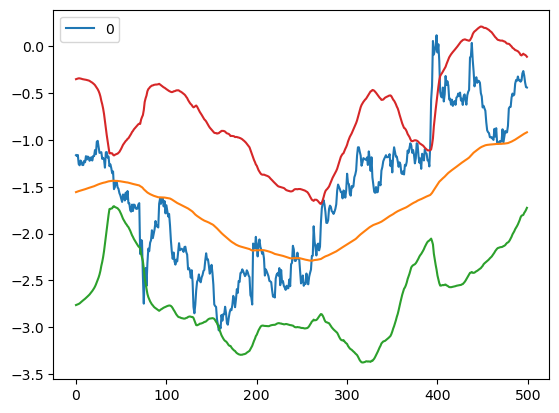

In [166]:
sns.lineplot((val_data@weight)[-500:])
sns.lineplot(ema[-500:])
sns.lineplot(buy_border_list[-500:])
sns.lineplot(sell_border_list[-500:])

(531, 22)
(531, 22)
(531, 22)


<Axes: >

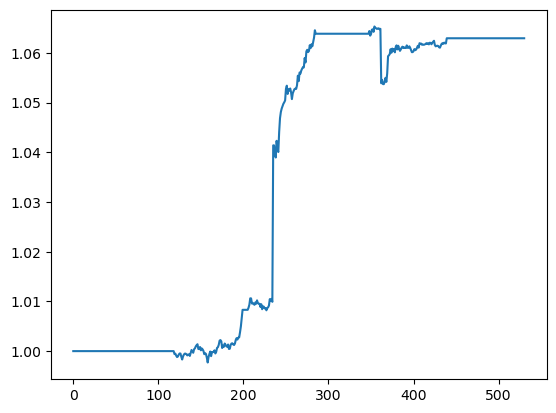

In [168]:
ema, buy_border_list, sell_border_list, val_data, portfolio, weight = mean_revision_signals(data2_test, z1, 100, 2, alpha=0.005)
sns.lineplot(np.cumprod(portfolio))
